# Титаник. Кто выживет?

https://www.kaggle.com/c/titanic/

In [4]:
import numpy as np
import pandas as pd

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

### Данные

In [11]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# EDA

In [15]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
train.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

In [17]:
sns.boxplot?

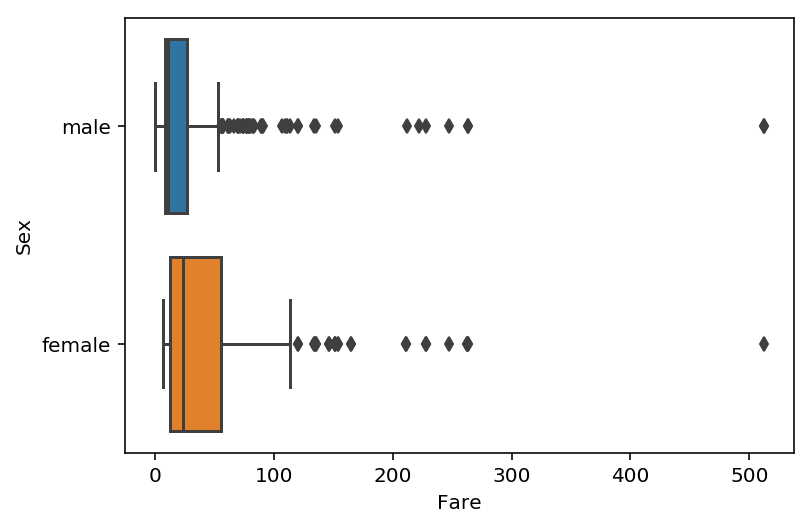

In [18]:
sns.boxplot(data=train, x='Fare', y='Sex')

In [19]:
train.groupby('Sex')['Pclass'].value_counts(normalize=True)

Sex     Pclass
female  3         0.458599
        1         0.299363
        2         0.242038
male    3         0.601386
        1         0.211438
        2         0.187175
Name: Pclass, dtype: float64

### Фичи

чтобы одинаковым образом обработать train и test и не дублировать все операции 2 раза, соединим эти два набора данных в один, не забыв при этом:
1. выкинуть целевую переменную из train
2. проверить на соответствие набора признаков друг другу
3. добавить флаг того, является ли объект тестовым или нет

In [20]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [21]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [22]:
train['is_test'] = 0
test['is_test'] = 1

In [23]:
df = pd.concat([train, test])

супер, теперь полный набор данных можно обрабатывать вместе и в любой момент, уже обработанными, обратно разъединить на обучающую и тестовую выборки

Пол male/female закодируем в 1/0 и удалим переменные, с которыми мы не будем сейчас работать

In [24]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

признаки, значения которых составляют небольшой перечислимый набор, закодируем в отдельные столбцы 

In [25]:
df.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [26]:
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [27]:
df_dummies.head(10)

,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,0,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,0,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,0,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,0,1,0,1,0,0


In [28]:
df_dummies.isnull().sum()

Age           263
SibSp           0
Parch           0
Fare            1
is_test         0
isMale          0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [29]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [30]:
columns = X_train.columns

In [31]:
X_train.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,1,0,1,0,0


### Заполнение пустых значений

заполним пустые значения средними по соответственным признакам

In [32]:
from sklearn.preprocessing import Imputer

In [33]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

/Users/gavril/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [34]:
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [35]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [36]:
X_train_imputed.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.000000,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,29.699118,0.0,0.0,8.4583,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,54.000000,0.0,0.0,51.8625,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,2.000000,3.0,1.0,21.0750,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,27.000000,0.0,2.0,11.1333,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,14.000000,1.0,0.0,30.0708,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Нормировка значений

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()

In [39]:
scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [41]:
X_train_imputed_scaled.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,-0.592481,0.432793,-0.473674,-0.502445,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
1,0.638789,0.432793,-0.473674,0.786845,-1.355574,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
2,-0.284663,-0.474545,-0.473674,-0.488854,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
3,0.407926,0.432793,-0.473674,0.420730,-1.355574,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
4,0.407926,-0.474545,-0.473674,-0.486337,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
5,0.000000,-0.474545,-0.473674,-0.478116,0.737695,-0.565685,-0.510152,0.902587,-0.482043,3.251373,-1.614710
6,1.870059,-0.474545,-0.473674,0.395814,0.737695,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
7,-2.131568,2.247470,0.767630,-0.224083,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
8,-0.207709,-0.474545,2.008933,-0.424256,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
9,-1.208115,0.432793,-0.473674,-0.042956,-1.355574,-0.565685,1.960202,-1.107926,2.074505,-0.307562,-1.614710


In [42]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

In [43]:
from sklearn.model_selection import train_test_split

### Разделение на обучающую и тестирующую выборки

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)

In [47]:
 X_val, y_val

(          Age     SibSp     Parch      Fare    isMale  Pclass_1  Pclass_2  \
 829  2.485693 -0.474545 -0.473674  0.962353 -1.355574  1.767767 -0.510152   
 228 -0.900298 -0.474545 -0.473674 -0.386671  0.737695 -0.565685  1.960202   
 610  0.715743  0.432793  5.732844 -0.018709 -1.355574 -0.565685 -0.510152   
 507  0.000000 -0.474545 -0.473674 -0.113846  0.737695  1.767767 -0.510152   
 149  0.946606 -0.474545 -0.473674 -0.386671  0.737695 -0.565685  1.960202   
 689 -1.131161 -0.474545  0.767630  3.606793 -1.355574  1.767767 -0.510152   
 350 -0.515526 -0.474545 -0.473674 -0.462679  0.737695 -0.565685 -0.510152   
 784 -0.361618 -0.474545 -0.473674 -0.506472  0.737695 -0.565685 -0.510152   
 714  1.716150 -0.474545 -0.473674 -0.386671  0.737695 -0.565685  1.960202   
 555  2.485693 -0.474545 -0.473674 -0.113846  0.737695  1.767767 -0.510152   
 557  0.000000 -0.474545 -0.473674  3.932723  0.737695  1.767767 -0.510152   
 738  0.000000 -0.474545 -0.473674 -0.489442  0.737695 -0.565685

In [48]:
X_train_fin.head()

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
134,-0.361618,-0.474545,-0.473674,-0.386671,0.737695,-0.565685,1.960202,-1.107926,-0.482043,-0.307562,0.619306
604,0.407926,-0.474545,-0.473674,-0.113846,0.737695,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
295,0.000000,-0.474545,-0.473674,-0.090272,0.737695,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
259,1.562241,-0.474545,0.767630,-0.124920,-1.355574,-0.565685,1.960202,-1.107926,-0.482043,-0.307562,0.619306
94,2.254830,-0.474545,-0.473674,-0.502445,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306


In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

In [54]:
depths = np.arange(1,10)
#features_num = np.arange(5,15)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [55]:
%%time
gridsearch.fit(X_train_fin, y_train_fin)

CPU times: user 245 ms, sys: 4.46 ms, total: 249 ms
Wall time: 251 ms


/Users/gavril/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [57]:

sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [58]:
scores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [59]:
clf_final = DecisionTreeClassifier(max_depth=5)

In [60]:
clf_final.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
y_pred_proba = clf_final.predict_proba( X_val)
y_pred = clf_final.predict(X_val)

In [62]:
y_pred

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1])